In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import extract_nba_rolling_stats

# Parameters and Data

In [5]:
def pull_preprocess_data(rolling_period = 62,
                         stat_cats = ['pts']):
    user_params = extract_nba_rolling_stats\
                      .UserParameters(rolling_period = rolling_period,
                                     stat_cats = stat_cats)

    script_run_extract = extract_nba_rolling_stats\
                            .run_extract(roll_period = rolling_period,
                                         categories = stat_cats)
    
    extracted_data = script_run_extract.extracted_data
    
    rolling_data = script_run_extract.rolling_shifted_data

    standardized_data = script_run_extract.standardized_data

    for cat in stat_cats:
        standardized_data[cat+'_normed'] = standardized_data[cat].apply(lambda x: (x**(1/2)).real)
        
        # Remove Outliers
        third_quart = np.percentile(standardized_data[cat], 75, method='midpoint')
        first_quart = np.percentile(standardized_data[cat], 25, method='midpoint')

        interquartile_range = third_quart - first_quart
        
        upper = third_quart + (1.5*interquartile_range)

        standardized_data.drop(standardized_data[standardized_data[cat] > upper].index,
                 inplace = True)

        # Normalize Data
        standardized_data[cat+'_normed'] = standardized_data[cat].apply(lambda x: (x**(1/2)).real)

        # Categorize if average was met by player
        standardized_data[cat+'_avg_met'] = (standardized_data['fpts'] >= standardized_data['player_fpts_mean']).apply(int)

    # Dummify Data
    data_dummied = pd.get_dummies(data = standardized_data.dropna(how = 'any'),
                              columns= ['player_position'],
                              dtype = int)
    
    return data_dummied

In [6]:
for i in [50, 60, 70]:
    data = pull_preprocess_data(rolling_period = i,
                                stat_cats = ['fpts'])

    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %i])

    with pd.ExcelWriter(excel_path) as writer:
        data.to_excel(writer,
                      index = False)

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!
Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!
Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting da

# Pipeline

## Model Metrics

In [2]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, classification_report

In [3]:
ran_state = 130

In [4]:
def split_train_test(data):

    unique_game_dates = data[data['game_date'] >= '2022-01-01']['game_date'].unique()

    # Take 2023 and beyond to adjust for the rolling statistic
    split_date = unique_game_dates[int(len(unique_game_dates) * 0.7)]
    
    train = data[data['game_date'] <= split_date]
    test = data[data['game_date'] > split_date]
        
        # Independent and Dependent variables
    ## Complete
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_stand' in col))
    #  )
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    ## Try
    # ((('player_' in col)
    #    & ('mean' in col)
    #    & ('league' not in col))
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    X_cols = [col for col in data.columns if ((('_mean_stand' in col)
                                               & ('league' not in col))
                                              | (col == 'min_stand')
                                              # | (('team_' in col)
                                              #    & ('_pg_stand' in col)
                                              #    & ('opp_' not in col))
                                              | (('opponent_team_opp_pos' in col)
                                                 & ('_pg' in col)
                                                & ('_stand' in col))
                                             )
             ]
    y_cols = [col for col in data.columns if '_avg_met' in col]
    
    # Training set
    X_train = train[X_cols].dropna()
    y_train = train.loc[X_train.index,
                        y_cols]
    
    # Test set
    X_test = test[X_cols].dropna()
    y_test = test.loc[X_test.index,
                    y_cols]
    
    return X_train, X_test, y_train, y_test

## SKLearn NN

In [ ]:
nn_performances = pd.DataFrame()

for p in [60,15,30,82]:
    print('Rolling period = %i' %p)

    # Read in data
    print('Reading data...')
    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %p])

    data = pd.read_excel(excel_path,
                         header = 0)

    # Train-test split
    X_train, X_test, y_train, y_test = split_train_test(data)

    print(*X_train.columns, sep = ', ')
    print(*y_train.columns, sep = ', ')
    
    # Randomized Search CV
    print('Performing RandomSearchCV...')
    ran_hidden_layers = [(5,2),
                         (5,5,2),
                         (2,5,2),
                         (3,3,3),
                         (10,5,2),
                         (3,3,3,3,3)]
    ran_activation = ['relu','logistic']
    ran_learning_rate = [0.001, 0.01, 0.1, 0.0001]
    
    ran_nn_params = {'hidden_layer_sizes':ran_hidden_layers,
                     'activation':ran_activation,
                    'learning_rate_init':ran_learning_rate}

    nn_regress_ranCV = RandomizedSearchCV(nn_regress,
                                          ran_nn_params,
                                          n_iter = 15,
                                         cv = 3,
                                         random_state = ran_state,
                                         verbose = 3)

    nn_regress_ranCV.fit(X_train,
                         y_train)

    ran_cv_performance = pd.DataFrame(nn_regress_ranCV.cv_results_).sort_values('rank_test_score')

    ran_cv_performance['rolling_period'] = p

    nn_performances = pd.concat([nn_performances,
                                 ran_cv_performance])

# Writer RandomSearchCV performance to excel
print('Writing results to Excel...')
ran_cv_performance_excel_path = '/'.join(['.','Data',
                                        'Random Search CV Performance_nn regressor.xlsx'])

with pd.ExcelWriter(ran_cv_performance_excel_path, mode = 'a') as writer:
    nn_performances.to_excel(writer,
                                sheet_name = 'FPTS min,mean,opp normed',
                                index = False)

In [ ]:
best_model = nn_regress_ranCV.best_estimator_

In [ ]:
y_pred_nn_ranCV = pd.DataFrame(best_model.predict(X_test),
                      columns = ['fpts_normed'])

In [ ]:
y_test['fpts'] = y_test['fpts_normed'].apply(lambda x: x**2)
y_pred_nn_ranCV['fpts'] = y_pred_nn_ranCV['fpts_normed'].apply(lambda x: x**2)

In [ ]:
mse = mean_squared_error(y_test[['fpts']],
                         y_pred_nn_ranCV[['fpts']],
                        squared = False)

r_squared = r2_score(y_test[['fpts']],
                     y_pred_nn_ranCV[['fpts']])

print('Root Mean Squared Error = %f' %mse)
print('R Squared = %f' %r_squared)

# Residual plot
residuals_rf = y_test['fpts'].values - y_pred_nn_ranCV['fpts'].values
print('Sum of residuals = %f' %sum(residuals_rf))

## Neural Network (keras)

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model

In [9]:
tf.random.set_seed(ran_state)
tf.keras.utils.set_random_seed(ran_state)
np.random.seed(ran_state)

Rolling period = 50
Reading data...
Splitting data...
opponent_team_opp_pos_fpts_pg_stand, fpts_mean_stand, min_stand
fpts_avg_met
Building NN...
Epoch 1/500
116/116 [==============================] - 3s 9ms/step - loss: 0.6792 - accuracy: 0.6120 - val_loss: 0.6544 - val_accuracy: 0.6688
Epoch 2/500
116/116 [==============================] - 1s 8ms/step - loss: 0.6236 - accuracy: 0.7021 - val_loss: 0.6145 - val_accuracy: 0.7238
Epoch 3/500
116/116 [==============================] - 1s 7ms/step - loss: 0.6023 - accuracy: 0.7166 - val_loss: 0.6042 - val_accuracy: 0.7189
Epoch 4/500
116/116 [==============================] - 1s 9ms/step - loss: 0.5923 - accuracy: 0.7219 - val_loss: 0.5931 - val_accuracy: 0.7201
Epoch 5/500
116/116 [==============================] - 1s 8ms/step - loss: 0.5840 - accuracy: 0.7211 - val_loss: 0.5851 - val_accuracy: 0.7216
Epoch 6/500
116/116 [==============================] - 1s 10ms/step - loss: 0.5789 - accuracy: 0.7207 - val_loss: 0.5778 - val_accuracy: 0.

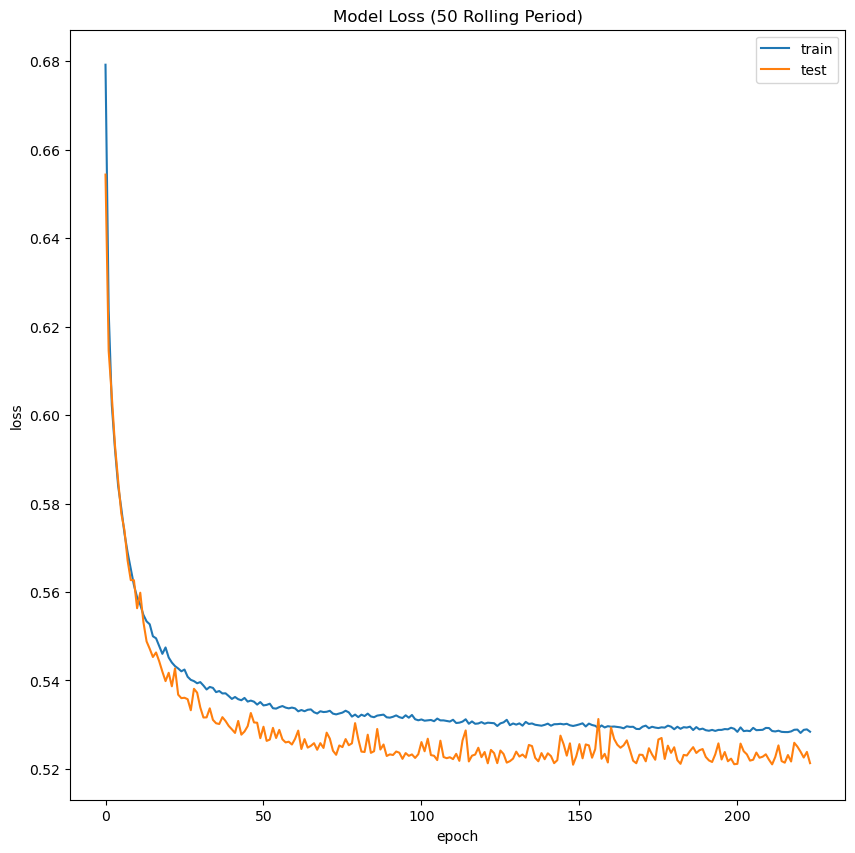

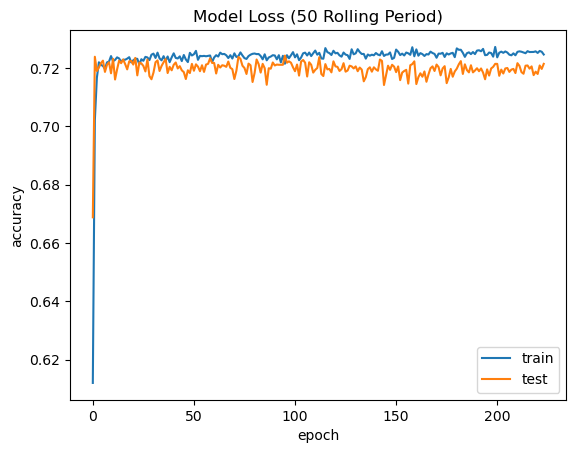

Minimum validation MSE: 0.520933
Maximum validation Accuracy: 0.724217


In [11]:
nn_performances = pd.DataFrame()

for p in [50]:
    print('Rolling period = %i' %p)

    # Read in data
    print('Reading data...')
    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %p])

    data = pd.read_excel(excel_path,
                         header = 0)

    print('Splitting data...')
    # Train-test split
    X_train, X_test, y_train, y_test = split_train_test(data)

    print(*X_train.columns, sep = ', ')
    print(*y_train.columns, sep = ', ')

    print('Building NN...')
    # Define keras NN model
    nn_regress_model = Sequential()

    nn_regress_model.add(Dense(50,
                               input_shape=(len(X_train.columns),),
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(50,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(10,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(5,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(5,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(1,
                               activation = 'sigmoid')
                         )

    # Compile model
    nn_regress_model.compile(loss = 'binary_crossentropy',
                             optimizer = 'adam',
                             metrics = ['accuracy',
                                        # 'R2Score'
                                       ]
                            )

    # Instansiate Early Stopping
    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   mode = 'min', # Searches for minimum val_loss (binary crossentropy)
                                   patience = 75,
                                   # min_delta = 1,
                                   # verbose = 1
                                  )
    # Fit model
    nn_regress_history = nn_regress_model.fit(X_train,
                                              y_train,
                                              validation_split = 0.3,
                                              epochs = 500,
                                              batch_size = 256,
                                              callbacks = [early_stopping],
                                              verbose = 1
                                             )
    
    print('Exporting model...')
    model_file_name = 'nn_class_fpts_(50,50,20,10,5,5)_%i rp' %p
    
    model_json = nn_regress_model.to_json()
    with open('./Models/%s.json' %model_file_name,'w') as json_file:
        json_file.write(model_json)

    nn_regress_model.save_weights('./Models/%s.h5' %model_file_name)

    # Plot training loss
    fig, ax = plt.subplots(figsize = (10,10))
    plt.plot(nn_regress_history.history['loss'])
    plt.plot(nn_regress_history.history['val_loss'])
    plt.title('Model Loss (%i Rolling Period)' %p)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','test'])
    plt.show()
    plt.plot(nn_regress_history.history['accuracy'])
    plt.plot(nn_regress_history.history['val_accuracy'])
    plt.title('Model Loss (%i Rolling Period)' %p)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train','test'])
    plt.show()

    print('Minimum validation MSE: %f' %min(nn_regress_history.history['val_loss']))
    print('Maximum validation Accuracy: %f' %max(nn_regress_history.history['val_accuracy']))

In [ ]:
# 50, 20, 10, 5
val_loss_60 = 0.505166, 0.737148
val_loss_15 = 0.515929, 0.729362
val_loss_30 = 0.513619, 0.733626
val_loss_82 = 0.502373, 0.737086

# 50, 50, 50, 50, 20, 20, 10, 10, 5
val_loss_60 = 0.505274, 0.736962
val_loss_15 = 0.517711, 0.729239
val_loss_30 = 0.512331, 0.733008
val_loss_82 = 0.502980, 0.736468

# 50, 50, 20, 20, 10, 10, 5
val_loss_60 = 0.505391, 0.737642
val_loss_15 = 0.515567, 0.728992
val_loss_30 = 0.514255, 0.732884
val_loss_82 = 0.503343, 0.737457

# 50, 50, 20, 20, 10, 10, 5 (sigmoid)
val_loss_50 = 0.506421, 0.737889
val_loss_60 = 0.505147, 0.737086
val_loss_70 = 0.504066, 0.736221

# 50, 50, 20, 10, 5, 5 (sigmoid)
val_loss_50 = 0.506325, 0.737951
val_loss_60 = 0.505245, 0.736715
val_loss_70 = 0.503894, 0.736406

# 50, 50, 20, 10, 5, 5 (last 2 sigmoid)
val_loss_50 = 0.507463, 0.737210
val_loss_60 = 0.505352, 0.737148
val_loss_70 = 0.505087, 0.736221

# 50, 50, 20, 10, 5, 5 (relu)
val_loss_50 = 0.505952, 0.737766
val_loss_60 = 0.505314, 0.737271
val_loss_70 = 0.505079, 0.736715

# 50, 50, 20 x 10, 10, 5, 5
val_loss_50 = 0.519542, 0.724532
val_loss_60 = 0.516084, 0.724138
val_loss_70 = 0.515489, 0.727287

# Best Model

In [ ]:
import json
from keras.models import model_from_json

best_model = model_from_json(open('./Models/nn_class_fpts_(50,50,20,10,5,5)_50 rp.json').read())

best_model.load_weights('./Models/nn_class_fpts_(50,50,20,10,5,5)_50 rp.h5')

In [ ]:
excel_path = '/'.join(['.','Data',
                        'modeling_data_50 rp_fpts.xlsx'])

data = pd.read_excel(excel_path,
                     header = 0)

In [ ]:
X_train, X_test, y_train, y_test = split_train_test(data)

In [ ]:
y_pred_nn = pd.DataFrame(best_model.predict(X_test),
                      columns = ['fpts_normed'])

In [ ]:
y_test['fpts'] = y_test['fpts_normed'].apply(lambda x: x**2)
y_pred_nn['fpts'] = y_pred_nn['fpts_normed'].apply(lambda x: x**2)

In [ ]:
mse_normed = mean_squared_error(y_test[['fpts_normed']],
                         y_pred_nn[['fpts_normed']],
                        squared = True)

rmse = mean_squared_error(y_test[['fpts']],
                         y_pred_nn[['fpts']],
                        squared = False)

r_squared = r2_score(y_test[['fpts']],
                     y_pred_nn[['fpts']])

print('Normed MSE = %f' %mse_normed)
print('Root Mean Squared Error = %f' %rmse)
print('R Squared = %f' %r_squared)

# Residual plot
residuals_rf = y_test['fpts'].values - y_pred_nn['fpts'].values
print('Sum of residuals = %f' %sum(residuals_rf))

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
sns.residplot(x = y_test['fpts'],
             y = y_pred_nn['fpts'])